In [3]:
#!./env/bin/ python3

# Import modules
import datetime as dt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt

In [20]:
# Choose a date range and pull data
end_date = dt.datetime.now()
start_date = dt.datetime(2018,1,1) # Year, month, day

yf.pdr_override()
df = pdr.get_data_yahoo('SCHD', start_date, end_date, progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,51.360001,51.369999,51.209999,51.330002,43.612030,794100
2018-01-03,51.320000,51.500000,51.220001,51.480000,43.739487,976300
2018-01-04,51.520000,51.799999,51.480000,51.730000,43.951897,823300
2018-01-05,51.849998,52.080002,51.750000,52.049999,44.223778,776200
2018-01-08,52.020000,52.189999,51.990002,52.160000,44.317238,886800


# Simple vs Log Returns
First, one period simple returns are given by:

$R_i=\dfrac{P_i-P_{i-1}}{P_{i-1}}=\dfrac{P_i}{P_{i-1}} - 1$

In [21]:
simple_returns = df.Close.pct_change().dropna()
simple_returns

Date
2018-01-03    0.002922
2018-01-04    0.004856
2018-01-05    0.006186
2018-01-08    0.002113
2018-01-09    0.000192
                ...   
2023-02-09   -0.008598
2023-02-10    0.009198
2023-02-13    0.011068
2023-02-14   -0.006568
2023-02-15    0.001945
Name: Close, Length: 1289, dtype: float64

For multi-period returns:

$1 + R_i(k) = \dfrac{P_i}{P_{i-1}}\dfrac{P_{i-1}}{P_{i-2}}\dfrac{P_{i-2}}{P_{i-3}}...\dfrac{P_{i-k+1}}{P_{i-k}}=\dfrac{P_{i}}{P_{i-k}}$

We also know that the total return is just the product of all the mid period returns

$1 + R_i(k)=(1+R_i)(1+R_{i-1})...(1+R_{i-k+1})$

Which can be written as

$1+R_i(k)=\Pi_{n=0}^{k-1}(1+R_{i-n})$

In [22]:
# Quickly test this out

# This is what we want to get
print('Starting Price: ${:.2f}   End Price: ${:.2f}'.format(df.Close[0], df.Close[-1]))

# Calculate this using list comprehension
end_price = df.Close[0] * np.prod([(1 + daily_return) for daily_return in simple_returns])
print('Calculated End Price: ${:.2f}'.format(end_price))

Starting Price: $51.33   End Price: $77.29
Calculated End Price: $77.29


Now consider Log Returns

$r_i=\ln(1+R_i)$

And for a period $k$ long,

$r_i(k)=\ln(1+R_i(k))=\ln[(1+R_i)(1+R_{i-1})(1+R_{i-2})...(1+R_{i-k+1})]$

$r_i(k)=\ln(1+R_i)+\ln(1+R_{i-1})+\ln(1+R_{i-2})+...+\ln(1+R_{i-k+1})$

$r_i(k)=r_i + r_{i-1} + r_{i-2} +...+r_{i-k+1}$

Using $1 + R_i(k)=\dfrac{P_{i}}{P_{i-k}}$ we can expand this again and cancel a bunch of middle terms to get:

$r_i(k)=\ln(P_i)-\ln(P_{i-k})$

In [23]:
# Now let's compute the log returns

log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
log_returns

Date
2018-01-03    0.002918
2018-01-04    0.004845
2018-01-05    0.006167
2018-01-08    0.002111
2018-01-09    0.000192
                ...   
2023-02-09   -0.008635
2023-02-10    0.009156
2023-02-13    0.011007
2023-02-14   -0.006590
2023-02-15    0.001943
Name: Close, Length: 1289, dtype: float64

In [24]:
# Because the final return is the SUM of log returns, it is NORMALLY DISTRIBUTED

mean_log_return = log_returns.mean()

# Recalculate close price
end_price = df.Close[0] * np.exp(mean_log_return * len(log_returns)) 
print('Calculated End Price: ${:.2f}'.format(end_price))

Calculated End Price: $77.29


<Axes: ylabel='Frequency'>

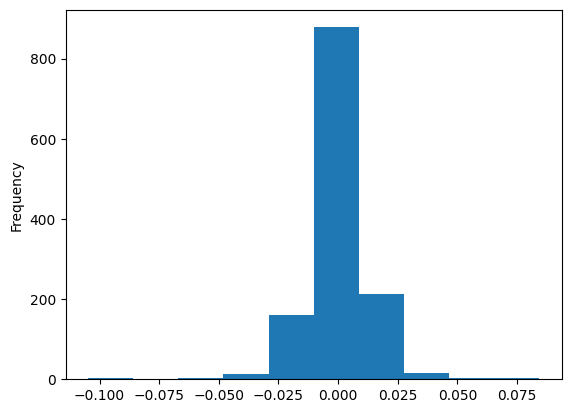

In [25]:
# Let's try to see the distribution of the log returns
log_returns.plot(kind='hist')

We can compare this data to a normal distribution using the Kolmogorov Smirnov Test (KS Test). This method can be used for any distribution, not only normal. To compare something to specifically the normal distribution you can use the Shapiro Wilk Test